In [1]:
!pip install -e ../Maccabee

Obtaining file:///home/jovyan/work/Maccabee
  Found existing installation: maccabee 0.0.12
    Uninstalling maccabee-0.0.12:
      Successfully uninstalled maccabee-0.0.12
  Running setup.py develop for maccabee


In [1]:
from maccabee.data_analysis import calculate_data_axis_metrics, gather_axis_metrics_for_given_params
from maccabee.constants import Constants
import maccabee.data_sources as data_sources
from maccabee.parameters import build_default_parameters, build_parameters_from_axis_levels

from maccabee.data_generation import SampledDataGeneratingProcess, data_generating_method

# benchmarks
from maccabee.benchmarking import benchmark_model_using_concrete_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp_grid

# genmatch
from maccabee.examples.genmatch import GenmatchDataGeneratingProcess, build_genmatch_datasource, GENMATCH_SPECS
from maccabee.examples.genmatch import LogisticPropensityMatchingCausalModel

In [2]:
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Define axes and metrics to analyze
axes_and_metrics = {
    Constants.AxisNames.OUTCOME_NONLINEARITY: [
        "Lin r2(X_obs, Y)",
        "Lin r2(X_true, Y)"
    ],
    Constants.AxisNames.TREATMENT_NONLINEARITY: [
        "Lin r2(X_obs, Treat Logit)"
    ],
    Constants.AxisNames.PERCENT_TREATED: [
        "Percent(T==1)"
    ],
    Constants.AxisNames.BALANCE: [
        "Wass dist X_true: T=1<->T=0",
    ],
    Constants.AxisNames.ALIGNMENT: [
        "Lin r2(Y, Treat Logit)",
        "Lin r2(Y0, Treat Logit)"
    ],
    Constants.AxisNames.TE_HETEROGENEITY: [
        "std(TE)/std(Y)"
    ]
}

In [4]:
G_param_overrides = {
  "TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7, #
        "POLY_QUAD": 0.3, #0.3
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0.11, #0.11
        "INTERACTION_THREE_WAY": 0,
  },
  "OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0,
        "INTERACTION_THREE_WAY": 0,
  },
  "MIN_PROPENSITY_SCORE": 0.1,
  "MAX_PROPENSITY_SCORE": 0.9,
  "OUTCOME_NOISE_TAIL_THICKNESS": 1000,
  "SUBFUNCTION_CONSTANT_TAIL_THICKNESS": 1000,
  "TREATMENT_EFFECT_TAIL_THICKNESS": 1000
}

A_param_overrides = {
  "TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0.0,
        "INTERACTION_THREE_WAY": 0,
  },
  "OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0,
        "INTERACTION_THREE_WAY": 0,
  },
  "MIN_PROPENSITY_SCORE": 0.1,
  "MAX_PROPENSITY_SCORE": 0.9,
  "OUTCOME_NOISE_TAIL_THICKNESS": 1000,
  "SUBFUNCTION_CONSTANT_TAIL_THICKNESS": 1000,
  "TREATMENT_EFFECT_TAIL_THICKNESS": 1000
}

C_param_overrides = {
  "TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0.3,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0.0,
        "INTERACTION_THREE_WAY": 0,
  },
  "OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0,
        "INTERACTION_THREE_WAY": 0,
  },
  "MIN_PROPENSITY_SCORE": 0.1,
  "MAX_PROPENSITY_SCORE": 0.9,
  "OUTCOME_NOISE_TAIL_THICKNESS": 1000,
  "SUBFUNCTION_CONSTANT_TAIL_THICKNESS": 1000,
  "TREATMENT_EFFECT_TAIL_THICKNESS": 1000
}


## Param Validation

In [4]:
genmatch_dgp = GenmatchDataGeneratingProcess(
        *GENMATCH_SPECS["G"],
        n_observations=1000, analysis_mode=True)

n_genmatch_samples = 100

# TODO: it should be possible to get metric vals from multiple draws from a DGP
# and also to get metric vals from a parameterization of a DGP sampler.
# This code can then be replaced.
genmatch_metric_vals = defaultdict(lambda: defaultdict(list))
for _ in range(n_genmatch_samples):
    genmatch_dataset = genmatch_dgp.generate_dataset()
#     print(genmatch_dgp.base_outcome_expression)
    metrics = calculate_data_axis_metrics(genmatch_dataset, axes_and_metrics)
    
    for metric, measures in axes_and_metrics.items():
        for measure in measures:
            res = metrics[metric][measure]
            if res is not None:
                genmatch_metric_vals[metric][measure].append(res)

In [41]:
%%time

n_mc_samples = 25

dgp_params = build_parameters_from_axis_levels({
    Constants.AxisNames.TREATMENT_NONLINEARITY: Constants.AxisLevels.HIGH,
    Constants.AxisNames.OUTCOME_NONLINEARITY: Constants.AxisLevels.LOW,
    Constants.AxisNames.TE_HETEROGENEITY: Constants.AxisLevels.LOW,
    Constants.AxisNames.ALIGNMENT: Constants.AxisLevels.LOW
})

for param_name in param_overrides:
    dgp_params.set_parameter(param_name, param_overrides[param_name])

mc_metric_vals = gather_axis_metrics_for_given_params(
    dgp_params, axes_and_metrics, generate_genmatch_covars, n_trials=n_mc_samples)

CPU times: user 28.8 s, sys: 14.4 s, total: 43.2 s
Wall time: 19.9 s


In [42]:
for axes, metrics in axes_and_metrics.items():
    print(axes)
    for metric in metrics:
        print("\t", metric)
        print("\t\tGenmatch:", np.round(np.mean(genmatch_metric_vals[axes][metric]), 3))
        print("\t\tMC:", np.round(np.mean(mc_metric_vals[axes][metric]), 3))

OUTCOME_NONLINEARITY
	 Lin r2(X_obs, Y)
		Genmatch: 0.972
		MC: 0.889
	 Lin r2(X_true, Y)
		Genmatch: 0.973
		MC: 0.892
TREATMENT_NONLINEARITY
	 Lin r2(X_obs, Treat Logit)
		Genmatch: 0.872
		MC: 0.774
PERCENT_TREATED
	 Percent(T==1)
		Genmatch: 42.143
		MC: 49.664
BALANCE
	 Wass dist X_true: T=1<->T=0
		Genmatch: 0.049
		MC: 0.045
ALIGNMENT
	 Lin r2(Y, Treat Logit)
		Genmatch: 0.062
		MC: 0.117
	 Lin r2(Y0, Treat Logit)
		Genmatch: 0.021
		MC: 0.12
TE_HETEROGENEITY
	 std(TE)/std(Y)
		Genmatch: 0.0
		MC: 0.0


## Benchmarks

At config A, 20-50 matches across runs. Wide distro. Should investigate the stability of the concrete distro when n=1000.

At config G, 20-50 has much lower bias in the sampled benchmark. The concrete function appears to be a worst case scenario given that very similar functions experience much lower typical bias. The distribution is right tailed and so it is possible that the concrete func chosen is just an (un)lucky sample from right tail.

I will test this by permuting the variable order in the exact same functional form.

### Genmatch Concrete Benchmark

In [8]:
%%time

# Concrete Benchmark
dgp = GenmatchDataGeneratingProcess(
    *GENMATCH_SPECS["A"],
    n_observations=10000, analysis_mode=False)

genmatch_agg_results, genmatch_raw_results = benchmark_model_using_concrete_dgp(
    dgp=dgp,
    model_class=LogisticPropensityMatchingCausalModel,
    estimand=Constants.Model.ATE_ESTIMAND,
    num_runs=1,
    num_samples_from_dgp=100)

CPU times: user 37.2 s, sys: 40.6 s, total: 1min 17s
Wall time: 11.6 s


In [22]:
genmatch_agg_results

{'absolute mean bias %': 11.456,
 'absolute mean bias % (std)': 0.0,
 'root mean squared error': 0.09,
 'root mean squared error (std)': 0.0}

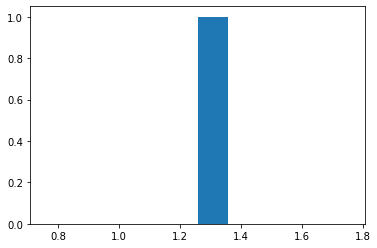

In [17]:
plt.hist(genmatch_raw_results["absolute mean bias %"])
plt.show()

### Sampled Benchmark

In [5]:
class NoiselessSampledDataGeneratingProcess(SampledDataGeneratingProcess):
    
    @data_generating_method(Constants.OUTCOME_NOISE_NAME, [])
    def _generate_outcome_noise_samples(self, input_vars):
        return 0

In [6]:
%%time

base_params = {
    Constants.AxisNames.TREATMENT_NONLINEARITY: Constants.AxisLevels.LOW,
    Constants.AxisNames.OUTCOME_NONLINEARITY: Constants.AxisLevels.LOW,
    Constants.AxisNames.TE_HETEROGENEITY: Constants.AxisLevels.LOW,
    Constants.AxisNames.ALIGNMENT: Constants.AxisLevels.LOW
}
dgp_params = build_parameters_from_axis_levels(base_params)
dgp_params.set_parameters(A_param_overrides)


mc_agg_result, mc_raw_results = benchmark_model_using_sampled_dgp(
    dgp_params, build_genmatch_datasource(),
    dgp_class=NoiselessSampledDataGeneratingProcess,
    model_class=LogisticPropensityMatchingCausalModel,
    estimand=Constants.Model.ATE_ESTIMAND,
    num_dgp_samples=10,
    num_samples_from_dgp=10,
    dgp_kwargs={"analysis_mode": False})

CPU times: user 8.4 s, sys: 337 ms, total: 8.74 s
Wall time: 8.16 s


In [7]:
mc_agg_result

{'absolute mean bias %': 362.075,
 'absolute mean bias % (std)': 423.308,
 'root mean squared error': 1.481,
 'root mean squared error (std)': 0.704}

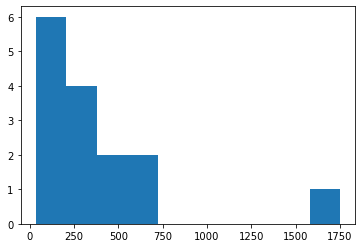

In [8]:
plt.hist(mc_raw_results["absolute mean bias %"])
plt.show()

In [24]:
index = 0
print(all_results["absolute mean bias %"][index])
all_results["eqn"][index]

0.4445964896003985


Max(-2.19722457733622, Min(2.19722457733622, -0.673276852805541*X1 + 0.0886843166329879*X10**2 - 0.157459909123876*X10 + 0.184608169317648*X2 - 0.300440746144408*X3 - 0.0416273322971168*X4 - 0.0217186081550174*X5 + 0.15384014109804*X7**2 - 0.115572809911108))